In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

MAX_ROWS = 250
MAX_COLS = 100

pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', MAX_COLS)
pd.options.mode.chained_assignment = None  # default='warn'

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"../data/{prefix}_message_5.csv"
orderbook_data_file = f"../data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction',
),
    skiprows=1
)

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

class OrderbookEventTypes(IntEnum):
    Limit=1
    PartialCancel=2
    Deletion=3
    ExecutionOfVisibleOrder=4
    ExecutionOfHiddenOrder=5
    TradingHalt=7

class OrderbookIndexes(IntEnum):
    Bid=0
    Ask=1

class OrderbookTypes(IntEnum):
    Limit=0
    Market=1
    Cancel=2

# Remove hidden orderbook events
df = df[
    # (df['type'] != OrderbookEventTypes.ExecutionOfHiddenOrder) & 
    (df['type'] != OrderbookEventTypes.TradingHalt) &
    (df['time'])
    ]

DEPTH = 3
ORDER_TYPES = 3
PRICE_TICK = 100
HALF_PRICE_TICK = PRICE_TICK / 2
NORMALIZED_QUEUE_MAX = 50

# 2.2.2 Estimation of the reference price

In [3]:
df['midprice'] = (df['bid1_price'] + df["ask1_price"]) / 2
spread = df["ask1_price"] - df['bid1_price']

spread_conditions = [
    df['midprice'] % PRICE_TICK != 0,
    df["ask1_size"] >= df['bid1_size'],
    df["ask1_size"] < df['bid1_size'],
]

midpoint_leans = [
    df['midprice'],
    df['midprice'] + HALF_PRICE_TICK,
    df['midprice'] - HALF_PRICE_TICK,
]

df['reference_price'] = np.select(spread_conditions, midpoint_leans)

## Normalize data around reference price

In [4]:
for depth_level in range(0, DEPTH):
    price_depth = HALF_PRICE_TICK + (PRICE_TICK * depth_level)

    bid_price_level = df['reference_price'] - price_depth
    ask_price_level = df['reference_price'] + price_depth

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'],
        df['bid2_size'],
        df['bid3_size'],
        df['bid4_size'],
        df['bid5_size']
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{depth_level + 1}_price'] = bid_price_level
    df[f'norm_bid{depth_level + 1}_size'] = np.select(bid_conditions, bid_choices)
    
    df[f'norm_ask{depth_level + 1}_price'] = ask_price_level
    df[f'norm_ask{depth_level + 1}_size'] = np.select(ask_conditions, ask_choices)

df.drop(columns=[
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
], inplace=True)
display(df)

,time,type,orderId,size,price,direction,event_lapse,midprice,reference_price,norm_bid1_price,norm_bid1_size,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size
0,34200.006241,1.0,16114545.0,100.0,275200.0,-1.0,0.000000,275150.0,275150.0,275100.0,400,275200.0,66,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
1,34200.006462,1.0,16114695.0,100.0,275500.0,-1.0,0.000221,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
2,34200.048864,3.0,16063194.0,100.0,275000.0,1.0,0.042402,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
3,34200.048883,3.0,15833239.0,100.0,275100.0,1.0,0.000020,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373
4,34200.048989,1.0,16127246.0,100.0,275000.0,1.0,0.000106,275150.0,275150.0,275100.0,300,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581024,57599.860444,3.0,287139444.0,34600.0,267200.0,-1.0,0.011408,267150.0,267150.0,267100.0,7191,267200.0,122704,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774
581025,57599.860635,1.0,287166269.0,16600.0,267000.0,1.0,0.000191,267150.0,267150.0,267100.0,7191,267200.0,88104,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774
581026,57599.870108,3.0,287016725.0,600.0,267400.0,-1.0,0.009473,267150.0,267150.0,267100.0,7191,267200.0,88104,267000.0,47783,267300.0,171683,266900.0,28495,267400.0,109774
581027,57599.939645,1.0,287173095.0,100.0,267200.0,-1.0,0.069536,267150.0,267150.0,267100.0,7191,267200.0,88104,267000.0,47783,267300.0,171683,266900.0,28495,267400.0,109174


### 2.3 Model I: Collection of independent queues
Figure 1: Limit order book

In [5]:
def getOrdersFromData(dataframe, depth, isBid):
    directionCode = 1 if isBid else -1
    
    limitOrder = (dataframe['type'] == 1)
    cancelOrder = (dataframe['type'] == 2) | (dataframe['type'] == 3)
    
    marketOrderCondititons = (
        (dataframe['type'] == 4) &
        (dataframe[f'norm_bid{depth}_size'] > 0) &
        (dataframe['direction'] == directionCode)
    )

    return (dataframe[limitOrder], dataframe[cancelOrder], dataframe[marketOrderCondititons])

In [6]:
is_event_in_bid = [
    (df['norm_bid1_price'] == df['price']),
    (df['norm_bid2_price'] == df['price']),
    (df['norm_bid3_price'] == df['price']),
]
is_event_in_ask = [
    (df['norm_ask1_price'] == df['price']),
    (df['norm_ask2_price'] == df['price']),
    (df['norm_ask3_price'] == df['price']),
]

average_event_sizes = np.zeros(DEPTH)
data_frames_at_depth = np.array([None] * DEPTH)

# When the following code is ran on a small subset of values, they get a different aes, and that will mess up the lmabdas calculation
# TODO: normalization code
for depth_level in range(0, DEPTH):
    orders_at_depth = df.loc[(is_event_in_bid[depth_level]) | (is_event_in_ask[depth_level])]
    
    bids_at_depth = orders_at_depth.loc[is_event_in_bid[depth_level]]
    asks_at_depth = orders_at_depth.loc[is_event_in_ask[depth_level]]

    merged = pd.concat([bids_at_depth, asks_at_depth])
    average_event_sizes[depth_level] = merged['size'].mean()

    bids_at_depth.loc[:, 'queue_length'] = np.ceil(bids_at_depth[f'norm_bid{depth_level + 1}_size'].astype(float) / average_event_sizes[depth_level])
    asks_at_depth.loc[:, 'queue_length'] = np.ceil(asks_at_depth[f'norm_ask{depth_level + 1}_size'].astype(float) / average_event_sizes[depth_level])

    merged = pd.concat([bids_at_depth, asks_at_depth])

    print(f'Price Level {depth_level + 1} | AES {average_event_sizes[depth_level]}')
        
    for queue_index in range(0, NORMALIZED_QUEUE_MAX):
        merged['queue_index'] = queue_index
        merged['dt_order'] = merged['time'].diff().fillna(0)
        
    data_frames_at_depth[depth_level] = merged
    
display(data_frames_at_depth[0])
display(data_frames_at_depth[1])
display(data_frames_at_depth[2])

Price Level 1 | AES 482.0589339516981
Price Level 2 | AES 457.3303913694279
Price Level 3 | AES 450.61269209508015


,time,type,orderId,size,price,direction,event_lapse,midprice,reference_price,norm_bid1_price,norm_bid1_size,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size,queue_length,queue_index,dt_order
3,34200.048883,3.0,15833239.0,100.0,275100.0,1.0,0.000020,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373,1.0,49,0.000000
11,34200.211338,5.0,0.0,125.0,275200.0,-1.0,0.000000,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,300,275400.0,373,275000.0,300,275500.0,100,0.0,49,0.162455
48,34200.212012,1.0,16168872.0,100.0,275200.0,-1.0,0.000039,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,300,275400.0,373,275000.0,300,275500.0,100,0.0,49,0.000674
50,34200.233926,5.0,0.0,100.0,275200.0,-1.0,0.000000,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,300,275400.0,373,275000.0,300,275500.0,100,0.0,49,0.021914
72,34200.234321,1.0,16174177.0,100.0,275200.0,-1.0,0.000003,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,800,275400.0,373,275000.0,300,275500.0,100,0.0,49,0.000395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581006,57599.627845,3.0,287149649.0,1500.0,267200.0,-1.0,0.000052,267150.0,267150.0,267100.0,7791,267200.0,123804,267000.0,32083,267300.0,173283,266900.0,29695,267400.0,109774,257.0,49,0.010125
581022,57599.834218,3.0,287092542.0,600.0,267200.0,-1.0,0.197321,267150.0,267150.0,267100.0,7191,267200.0,122304,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774,254.0,49,0.206373
581023,57599.849036,1.0,287165837.0,1000.0,267200.0,-1.0,0.014818,267150.0,267150.0,267100.0,7191,267200.0,121704,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774,253.0,49,0.014818
581024,57599.860444,3.0,287139444.0,34600.0,267200.0,-1.0,0.011408,267150.0,267150.0,267100.0,7191,267200.0,122704,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774,255.0,49,0.011408


,time,type,orderId,size,price,direction,event_lapse,midprice,reference_price,norm_bid1_price,norm_bid1_size,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size,queue_length,queue_index,dt_order
2,34200.048864,3.0,16063194.0,100.0,275000.0,1.0,0.042402,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373,1.0,49,0.000000
4,34200.048989,1.0,16127246.0,100.0,275000.0,1.0,0.000106,275150.0,275150.0,275100.0,300,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373,0.0,49,0.000125
8,34200.049301,1.0,16127367.0,200.0,275000.0,1.0,0.000190,275150.0,275150.0,275100.0,300,275200.0,166,275000.0,100,275300.0,1000,274900.0,700,275400.0,373,1.0,49,0.000311
12,34200.211455,1.0,16168655.0,200.0,275100.0,1.0,0.000117,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,300,275400.0,373,275000.0,300,275500.0,100,1.0,49,0.162155
13,34200.211462,1.0,16168657.0,100.0,275100.0,1.0,0.000007,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,500,275400.0,373,275000.0,300,275500.0,100,2.0,49,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580989,57599.617646,3.0,287063308.0,400.0,267300.0,-1.0,0.000019,267150.0,267150.0,267100.0,7891,267200.0,124204,267000.0,33483,267300.0,174583,266900.0,30195,267400.0,110674,382.0,49,0.002215
580992,57599.618939,3.0,287053300.0,400.0,267300.0,-1.0,0.001220,267150.0,267150.0,267100.0,7891,267200.0,123804,267000.0,33083,267300.0,174183,266900.0,30195,267400.0,110674,381.0,49,0.001294
580996,57599.619386,3.0,287082780.0,500.0,267300.0,-1.0,0.000419,267150.0,267150.0,267100.0,7891,267200.0,123804,267000.0,32683,267300.0,173783,266900.0,29795,267400.0,110274,380.0,49,0.000447
581007,57599.627869,3.0,287049482.0,1500.0,267300.0,-1.0,0.000024,267150.0,267150.0,267100.0,7791,267200.0,122304,267000.0,32083,267300.0,173283,266900.0,29695,267400.0,109774,379.0,49,0.008483


,time,type,orderId,size,price,direction,event_lapse,midprice,reference_price,norm_bid1_price,norm_bid1_size,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size,queue_length,queue_index,dt_order
5,34200.049011,1.0,16127264.0,500.0,274900.0,1.0,0.000022,275150.0,275150.0,275100.0,300,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373,1.0,49,0.000000
97,34200.439890,1.0,1333266.0,200.0,275000.0,1.0,0.000000,275250.0,275250.0,275200.0,980,275300.0,1000,275100.0,404,275400.0,673,275000.0,300,275500.0,250,1.0,49,0.390879
99,34200.439890,1.0,2618596.0,6281.0,275000.0,1.0,0.000000,275250.0,275250.0,275200.0,980,275300.0,1000,275100.0,404,275400.0,673,275000.0,500,275500.0,400,2.0,49,0.000000
101,34200.439890,1.0,2618605.0,100.0,275000.0,1.0,0.000000,275250.0,275250.0,275200.0,980,275300.0,1000,275100.0,404,275400.0,673,275000.0,6781,275500.0,400,16.0,49,0.000000
102,34200.439890,1.0,2618609.0,100.0,275000.0,1.0,0.000000,275250.0,275250.0,275200.0,980,275300.0,1000,275100.0,404,275400.0,673,275000.0,6881,275500.0,400,16.0,49,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580904,57599.095240,1.0,287125870.0,700.0,267400.0,-1.0,0.024157,267150.0,267150.0,267100.0,15191,267200.0,65004,267000.0,20683,267300.0,160683,266900.0,30195,267400.0,93974,209.0,49,0.066893
580953,57599.395795,1.0,287147791.0,16000.0,267400.0,-1.0,0.092356,267150.0,267150.0,267100.0,15731,267200.0,65504,267000.0,34683,267300.0,174683,266900.0,29895,267400.0,94674,211.0,49,0.300554
580995,57599.618967,3.0,286879178.0,400.0,267400.0,-1.0,0.000017,267150.0,267150.0,267100.0,7891,267200.0,123804,267000.0,32683,267300.0,173783,266900.0,29795,267400.0,110674,246.0,49,0.223172
580998,57599.620722,3.0,279359740.0,500.0,267400.0,-1.0,0.000049,267150.0,267150.0,267100.0,7891,267200.0,123804,267000.0,32183,267300.0,173283,266900.0,29795,267400.0,110274,245.0,49,0.001754


In [7]:
lambdas = np.array([None] * DEPTH)

def generateIntensityValues(dataframe, depth_level=0):
    lambdas = np.zeros((2, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

    is_event_in_bid = [
        (df['norm_bid1_price'] == df['price']),
        (df['norm_bid2_price'] == df['price']),
        (df['norm_bid3_price'] == df['price']),
    ]
    is_event_in_ask = [
        (df['norm_ask1_price'] == df['price']),
        (df['norm_ask2_price'] == df['price']),
        (df['norm_ask3_price'] == df['price']),
    ]

    orders_at_depth = dataframe.loc[(is_event_in_bid[depth_level]) | (is_event_in_ask[depth_level])]

    bids_at_depth = orders_at_depth.loc[is_event_in_bid[depth_level]]
    asks_at_depth = orders_at_depth.loc[is_event_in_ask[depth_level]]
    
    for queue_index in range(0, NORMALIZED_QUEUE_MAX):
        bid_queue = bids_at_depth.loc[bids_at_depth['queue_length'] == queue_index]
        ask_queue = asks_at_depth.loc[asks_at_depth['queue_length'] == queue_index]
        
        dt_order = data_frames_at_depth[depth_level]['dt_order'].mean()

        bidLimitOrder, bidCancelOrder, bidMarketOrderCondititons  = getOrdersFromData(bid_queue, depth_level + 1, True)
        askLimitOrder, askCancelOrder, askMarketOrderCondititons = getOrdersFromData(ask_queue, depth_level + 1, False)
        
        numberOfOrdersAtBidQueue = len(bid_queue)
        numberOfOrdersAtAskQueue = len(ask_queue)

        bid_denominator = numberOfOrdersAtBidQueue * dt_order
        if(bid_denominator == 0 or np.isnan(bid_denominator)):
            bid_denominator = 0.0000001
        
        ask_denominator = numberOfOrdersAtAskQueue * dt_order
        if(ask_denominator == 0 or np.isnan(ask_denominator)):
            ask_denominator = 0.0000001

        bidLimitIntensity = (len(bidLimitOrder)) / (bid_denominator)
        bidCancelIntensity = (len(bidCancelOrder)) / (bid_denominator)
        bidMarketIntensity = (len(bidMarketOrderCondititons)) / (bid_denominator)
        
        askLimitIntensity = (len(askLimitOrder)) / (ask_denominator)
        askCancelIntensity = (len(askCancelOrder)) / (ask_denominator)
        askMarketIntensity = (len(askMarketOrderCondititons)) / (ask_denominator)

        lambdas[OrderbookIndexes.Bid, OrderbookTypes.Limit, queue_index] = bidLimitIntensity
        lambdas[OrderbookIndexes.Bid, OrderbookTypes.Market, queue_index] = bidMarketIntensity
        lambdas[OrderbookIndexes.Bid, OrderbookTypes.Cancel, queue_index] = bidCancelIntensity

        lambdas[OrderbookIndexes.Ask, OrderbookTypes.Limit, queue_index] = askLimitIntensity
        lambdas[OrderbookIndexes.Ask, OrderbookTypes.Market, queue_index] = askMarketIntensity
        lambdas[OrderbookIndexes.Ask, OrderbookTypes.Cancel, queue_index] = askCancelIntensity
    
    # if any values are nan, set them to 0
    lambdas = np.nan_to_num(lambdas)
    return lambdas

for depth_level in range(0, DEPTH):
    lambdas[depth_level] = generateIntensityValues(data_frames_at_depth[depth_level], depth_level)

### Figure 2: Intensities at Q+- i= 1, 2, 3

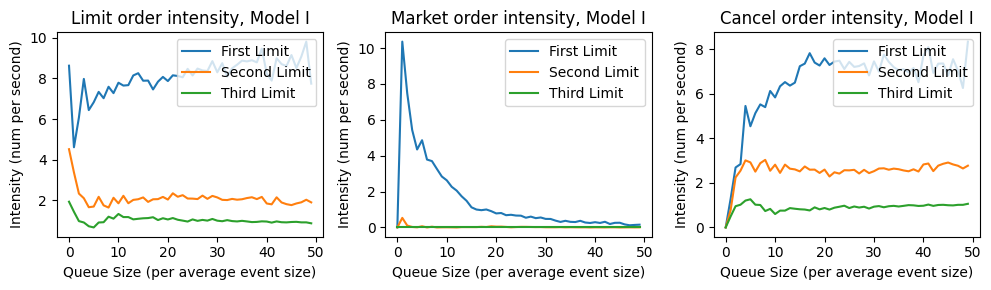

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for order_type in OrderbookTypes:
    axes[order_type].plot((lambdas[0][OrderbookIndexes.Bid][order_type] + lambdas[0][OrderbookIndexes.Ask][order_type]) / 2, label=f"First Limit")
    axes[order_type].plot((lambdas[1][OrderbookIndexes.Bid][order_type] + lambdas[1][OrderbookIndexes.Ask][order_type]) / 2, label=f"Second Limit")
    axes[order_type].plot((lambdas[2][OrderbookIndexes.Bid][order_type] +  lambdas[2][OrderbookIndexes.Ask][order_type]) / 2, label=f"Third Limit")
    
    if (order_type == OrderbookTypes.Limit):
        order_name = "Limit"
    elif (order_type == OrderbookTypes.Market):
        order_name = "Market"
    elif (order_type == OrderbookTypes.Cancel):
        order_name = "Cancel"

    axes[order_type].set_ylabel("Intensity (num per second)")
    axes[order_type].set_xlabel("Queue Size (per average event size)")
    axes[order_type].legend(loc='upper right')
    axes[order_type].set_title(f"{order_name} order intensity, Model I")
fig.tight_layout()
plt.show()

## 2.3.3 Asymptotic behavior under Model I

### Figure 3: Model I, invariant distributions of q±1, q±2, q±3, France Telecom

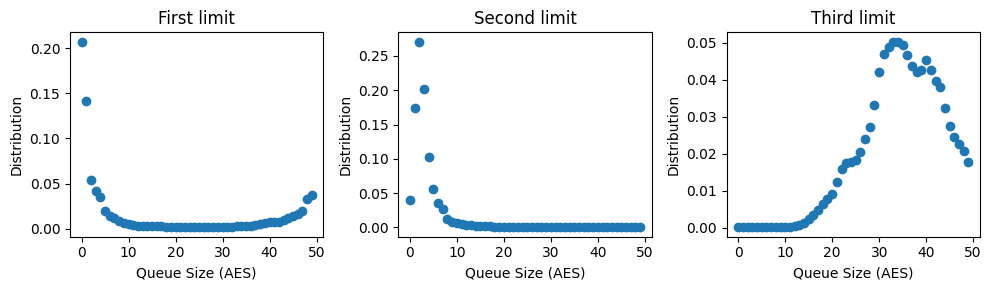

In [9]:
# Invarient Distibutions
def ArrivalDepartureRatio(depth, n):
    limitBid = lambdas[depth][OrderbookIndexes.Bid][0][n]
    cancelBid = lambdas[depth][OrderbookIndexes.Bid][1][n + 1]
    marketBid = lambdas[depth][OrderbookIndexes.Bid][2][n + 1]

    return (limitBid) / (cancelBid + marketBid)

def InvariantDistribution(depth, n):
    product = 1
    
    for j in range(0, n):
        ratio = ArrivalDepartureRatio(depth, j)
        product *= (ratio if ratio != 0 else 1) 

    return product

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for depth in range(0, DEPTH):
    sum = 0
    for n in range(0, NORMALIZED_QUEUE_MAX):
        sum += InvariantDistribution(depth, n)

    initial_distribution = 1 / (1 + sum)

    x_vals = np.linspace(0, NORMALIZED_QUEUE_MAX - 1, NORMALIZED_QUEUE_MAX)
    y_vals = [initial_distribution * InvariantDistribution(depth, int(x)) for x in x_vals]

    axes[depth].scatter(x_vals, y_vals)
    title = ['First', 'Second', 'Third']
    axes[depth].set_ylabel("Distribution")
    axes[depth].set_xlabel("Queue Size (AES)")
    axes[depth].set_title(f'{title[depth]} limit')
fig.tight_layout()
plt.show()

# 2.4.1 Model IIa: Two sets of dependent queues

### 2.4.2: Model IIa: Empiracal Study

Figure 4: Intensities at Q2 as functions of 1q1>0 and q2,

array([0.        , 3.67069654, 2.43622511, 1.4696976 , 1.59397645,
       1.60536199, 1.84454472, 1.73041737, 1.87292233, 2.24750679,
       2.02899919, 2.25444354, 2.16984904, 2.82705257, 2.14275012,
       3.14207364, 2.1649371 , 2.12832083, 1.85341272, 2.99449791,
       2.3590243 , 2.21975979, 2.2980642 , 2.45939295, 1.92094598,
       1.95912377, 1.68753154, 1.93238018, 2.12504649, 2.29524795,
       2.33074778, 2.15483278, 1.9764507 , 2.34115291, 1.98229005,
       2.03906866, 2.02190478, 2.39645573, 1.64612314, 1.30564297,
       2.27161371, 1.72222743, 2.48365787, 1.63880704, 1.68082773,
       2.07101988, 2.17781666, 2.58004606, 2.14925513, 2.70133028])

array([4.68230582, 3.19957564, 1.73914216, 1.62258122, 1.79699304,
       1.39308272, 2.48932714, 1.48400949, 1.41033308, 2.28912729,
       1.70972163, 2.19399473, 2.03310647, 1.91860336, 2.15221776,
       2.0536429 , 1.85677644, 2.0536429 , 2.0439787 , 2.00913486,
       1.94709747, 2.38175094, 2.03530158, 2.12685048, 2.02358327,
       1.90915445, 2.01730467, 2.21195021, 2.00113348, 2.20863482,
       2.0613925 , 1.92962981, 1.86189516, 1.99789344, 1.99031731,
       2.11328069, 1.97784247, 2.03946704, 1.98043146, 1.92550057,
       1.76859941, 1.96082121, 1.87558273, 2.02000072, 1.77078028,
       1.74973244, 1.81376566, 1.86128927, 1.97776785, 1.70595638])

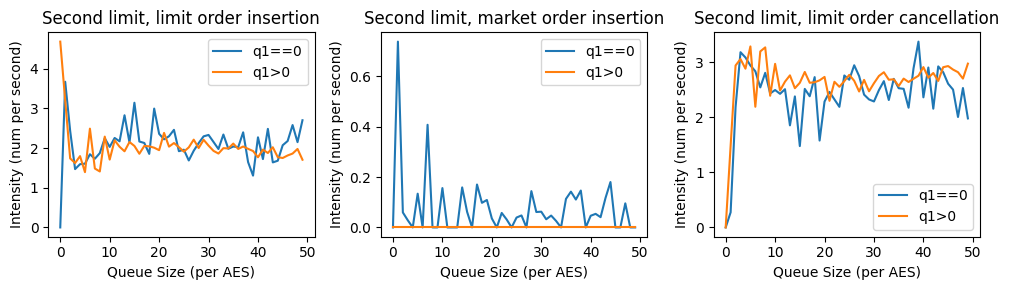

In [10]:
order_type_titles = ["limit order insertion", "market order insertion", "limit order cancellation"]

empty_queue_depth_level = 1

empty_top_bid_queue = data_frames_at_depth[empty_queue_depth_level]['norm_bid1_size'] == 0
top_bid_queue = data_frames_at_depth[empty_queue_depth_level]['norm_bid1_size'] != 0

empty_top_ask_queue = data_frames_at_depth[empty_queue_depth_level]['norm_ask1_size'] == 0
top_ask_queue = data_frames_at_depth[empty_queue_depth_level]['norm_ask1_size'] != 0

queue_empty_bid_lambdas = generateIntensityValues(data_frames_at_depth[empty_queue_depth_level][empty_top_bid_queue], empty_queue_depth_level)
queue_non_empty_bid_lambdas = generateIntensityValues(data_frames_at_depth[empty_queue_depth_level][top_bid_queue], empty_queue_depth_level)

display(queue_empty_bid_lambdas[OrderbookIndexes.Bid][OrderbookTypes.Limit])
display(queue_non_empty_bid_lambdas[OrderbookIndexes.Bid][OrderbookTypes.Limit])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for order_type in OrderbookTypes:
    axes[order_type].plot(queue_empty_bid_lambdas[OrderbookIndexes.Bid][order_type], label=f"q1==0")
    axes[order_type].plot(queue_non_empty_bid_lambdas[OrderbookIndexes.Bid][order_type], label=f"q1>0")
    
    axes[order_type].set_ylabel("Intensity (num per second)")
    axes[order_type].set_xlabel("Queue Size (per AES)")
    axes[order_type].legend()
    axes[order_type].set_title(f'Second limit, {order_type_titles[order_type]}')
fig.tight_layout()
plt.show()

### 2.4.3 Model IIa: Asympotic behavior

### 2.4.4 Model IIb: Modeling bid-ask dependences

In this model, market participants at Q±1 adjust their behavior not only according to the target queue size, but also to the size of the opposite queue.

In [11]:
queue_size_grouping_depth = 0

class QueueTypes(IntEnum):
    Q_empty = 0
    Q_small = 1
    Q_medium = 2
    Q_large = 3

bid_queue_size_33_percentile = data_frames_at_depth[queue_size_grouping_depth]['norm_bid1_size'].quantile(0.33)
ask_queue_size_33_percentile = data_frames_at_depth[queue_size_grouping_depth]['norm_ask1_size'].quantile(0.33)
bid_queue_size_66_percentile = data_frames_at_depth[queue_size_grouping_depth]['norm_bid1_size'].quantile(0.66)
ask_queue_size_66_percentile = data_frames_at_depth[queue_size_grouping_depth]['norm_ask1_size'].quantile(0.66)

def categorize_queue(queue_size, percentile_33, percentile_66):
    if(queue_size == 0):
        return QueueTypes.Q_empty
    elif(queue_size < percentile_33):
        return QueueTypes.Q_small
    elif(queue_size < percentile_66):
        return QueueTypes.Q_medium
    else:
        return QueueTypes.Q_large
    
data_frames_at_depth[queue_size_grouping_depth]['bid_queue_type'] = data_frames_at_depth[queue_size_grouping_depth]['norm_bid1_size'].apply(categorize_queue, args=(bid_queue_size_33_percentile, bid_queue_size_66_percentile))
data_frames_at_depth[queue_size_grouping_depth]['ask_queue_type'] = data_frames_at_depth[queue_size_grouping_depth]['norm_ask1_size'].apply(categorize_queue, args=(ask_queue_size_33_percentile, ask_queue_size_66_percentile))
print(data_frames_at_depth[queue_size_grouping_depth]['bid_queue_type'].mean())
print(data_frames_at_depth[queue_size_grouping_depth]['ask_queue_type'].mean())

1.903958901876653
1.822046598204849


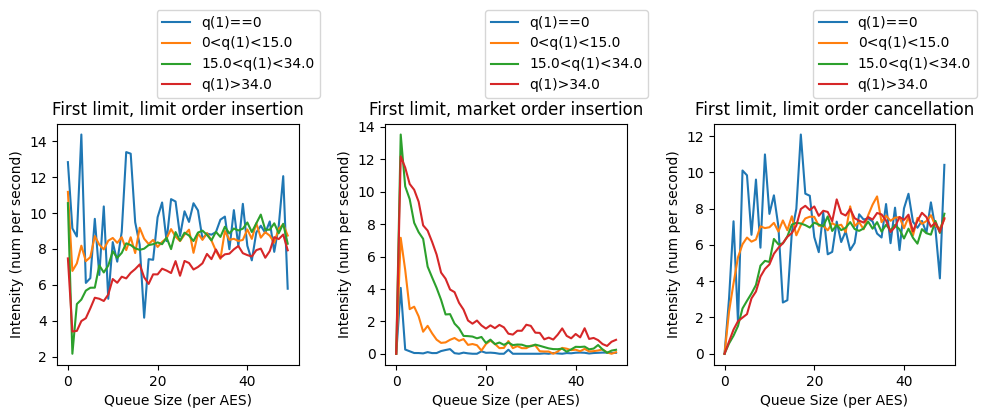

In [12]:
# The rates λL±1 and λC±1 are therefore modeled as functions of q±1 and Sm,l(q∓1).
order_type_titles = ["limit order insertion", "market order insertion", "limit order cancellation"]

bid_empty_queue = data_frames_at_depth[queue_size_grouping_depth]['bid_queue_type'] == 0
bid_small_queue = data_frames_at_depth[queue_size_grouping_depth]['bid_queue_type'] == 1
bid_medium_queue = data_frames_at_depth[queue_size_grouping_depth]['bid_queue_type'] == 2
bid_large_queue = data_frames_at_depth[queue_size_grouping_depth]['bid_queue_type'] == 3

ask_empty_queue = data_frames_at_depth[queue_size_grouping_depth]['ask_queue_type'] == 0
ask_small_queue = data_frames_at_depth[queue_size_grouping_depth]['ask_queue_type'] == 1
ask_medium_queue = data_frames_at_depth[queue_size_grouping_depth]['ask_queue_type'] == 2
ask_large_queue = data_frames_at_depth[queue_size_grouping_depth]['ask_queue_type'] == 3

bid_empty_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][bid_empty_queue], queue_size_grouping_depth)
bid_small_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][bid_small_queue], queue_size_grouping_depth)
bid_medium_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][bid_medium_queue], queue_size_grouping_depth)
bid_large_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][bid_large_queue], queue_size_grouping_depth)

ask_empty_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][ask_empty_queue], queue_size_grouping_depth)
ask_small_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][ask_small_queue], queue_size_grouping_depth)
ask_medium_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][ask_medium_queue], queue_size_grouping_depth)
ask_large_queue_lambdas = generateIntensityValues(data_frames_at_depth[queue_size_grouping_depth][ask_large_queue], queue_size_grouping_depth)

average_event_size = 500

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for order_type in OrderbookTypes:
    axes[order_type].plot(ask_empty_queue_lambdas[OrderbookIndexes.Bid][order_type], label=f"q(1)==0")
    axes[order_type].plot(ask_small_queue_lambdas[OrderbookIndexes.Bid][order_type], label=f"0<q(1)<{bid_queue_size_33_percentile // average_event_size}")
    axes[order_type].plot(ask_medium_queue_lambdas[OrderbookIndexes.Bid][order_type], label=f"{bid_queue_size_33_percentile // average_event_size}<q(1)<{bid_queue_size_66_percentile // average_event_size}")
    axes[order_type].plot(ask_large_queue_lambdas[OrderbookIndexes.Bid][order_type], label=f"q(1)>{bid_queue_size_66_percentile // average_event_size}")
    
    axes[order_type].set_ylabel("Intensity (num per second)")
    axes[order_type].set_xlabel("Queue Size (per AES)")
    axes[order_type].legend(loc='upper center', bbox_to_anchor=(0.5, 1, 0.5, 0.5))
    axes[order_type].set_title(f'First limit, {order_type_titles[order_type]}')
fig.tight_layout()
plt.show()


In [13]:
np.save('lambdas.npy', [
    [
    bid_empty_queue_lambdas,
    bid_small_queue_lambdas,
    bid_medium_queue_lambdas,
    bid_large_queue_lambdas
],[
    ask_empty_queue_lambdas,
    ask_small_queue_lambdas,
    ask_medium_queue_lambdas,
    ask_large_queue_lambdas
]])

import json

with open('lambda_markers.json', 'w') as f:
    json.dump({
        'bid_queue_size_33_percentile': bid_queue_size_33_percentile // average_event_sizes[0],
        'bid_queue_size_66_percentile': bid_queue_size_66_percentile // average_event_sizes[0],
        'ask_queue_size_33_percentile': ask_queue_size_33_percentile // average_event_sizes[0],
        'ask_queue_size_66_percentile': ask_queue_size_66_percentile // average_event_sizes[0],
    }, f)

### Example of application: Probabilty of execution

In [14]:
from IPython.display import Javascript
from nbconvert import HTMLExporter
import codecs
import nbformat

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

save_notebook()

In [15]:
current_file = 'queue-reactive.ipynb'
output_file = 'output_file.html'
output_HTML(current_file, output_file)